In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
import pickle
from configs.RecursiveVPSDE.LSTM_12DLorenz.recursive_LSTM_PostMeanScore_12DLorenz_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.LSTM_12DLorenz.recursive_LSTM_PostMeanScore_12DLorenz_10FC_T256_H05_tl_110data_StbleTgt import get_config
from configs.RecursiveVPSDE.LSTM_12DLorenz.recursive_LSTM_PostMeanScore_12DLorenz_125FC_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
num_paths = 11317
config = get_config()

In [3]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_dir+file)
            elif "local" in file:
                local_files.append(root_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [4]:
config = get_config()
true_files, local_files, bws = get_drift_files(config=config)
local_files

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f12DLnz_DriftTrack_00001bw_11317NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f12DLnz_DriftTrack_0000126bw_11317NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f12DLnz_DriftTrack_0000159bw_11317NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f12DLnz_DriftTrack_0000201bw_11317NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f12DLnz_DriftTrack_0000254bw_11317NPaths_00t0_3906e-03dT_125FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f12DLnz_DriftTrack_0000321bw_11317NPaths_00t0_3906e-03dT_125FC

nan nan inf 0
nan nan inf 1
nan nan inf 2
nan nan inf 3
0.28041575032611343 0.0 inf 4


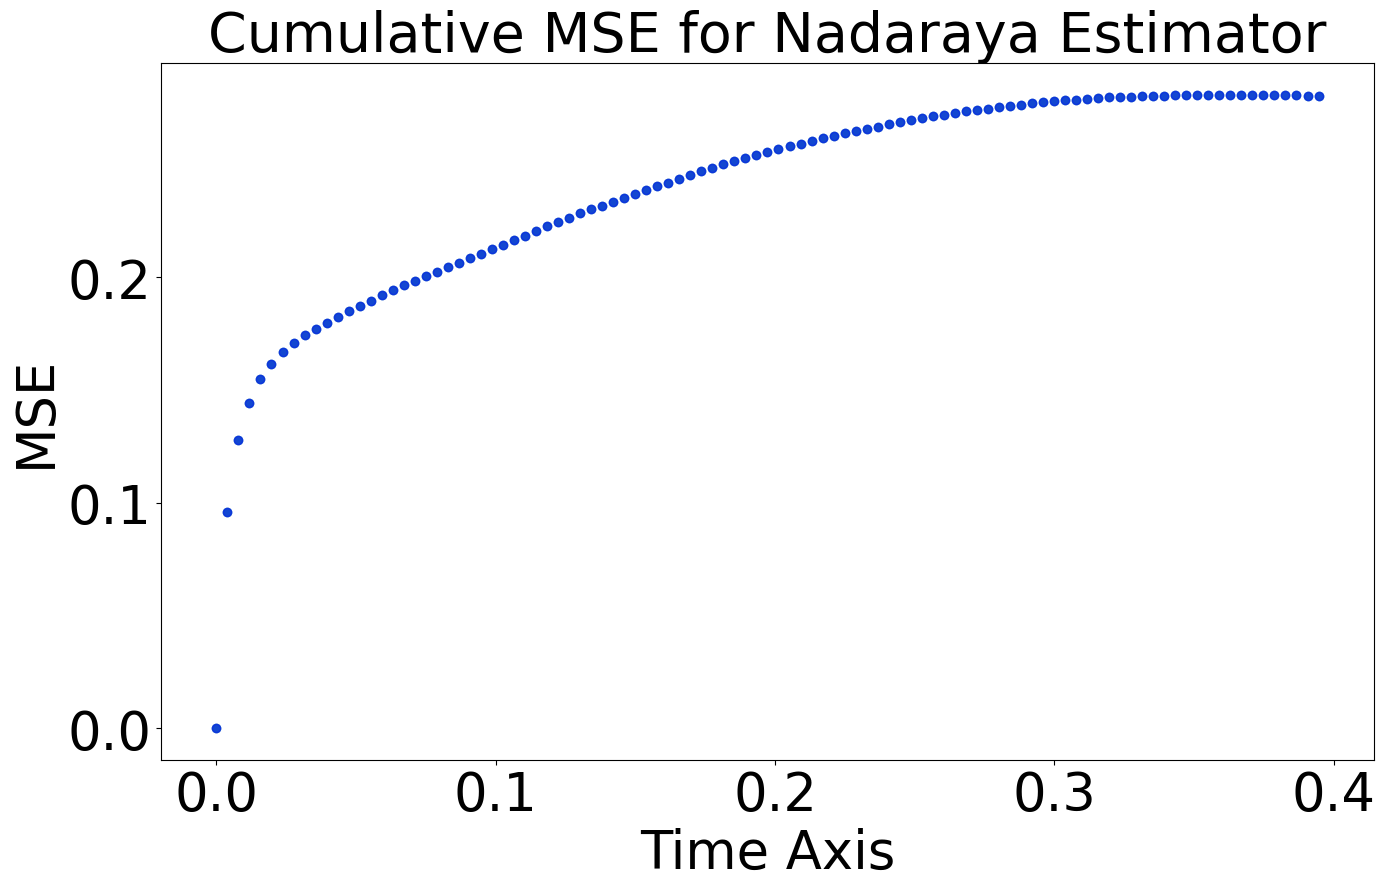

Final time cumulative MSE local-time error 0.28041575032611343 with IQR ((0.28041575032611343, 0.28041575032611343))at bw 2.54e-05 for 1.25FConst

0.28041575032611343 0.0 0.28041575032611343 5
0.28041575032611343 0.0 0.28041575032611343 6
0.28041575032611343 0.0 0.28041575032611343 7
0.28041575032611343 0.0 0.28041575032611343 8
0.28041575032611343 0.0 0.28041575032611343 9
0.28041575032611343 0.0 0.28041575032611343 10
0.28041575032611343 0.0 0.28041575032611343 11
0.28371255306787446 0.0 0.28041575032611343 12
0.28371255306787446 0.0 0.28041575032611343 13
0.28371255306787446 0.0 0.28041575032611343 14
0.28371255306787446 0.0 0.28041575032611343 15
0.28371255306787446 0.0 0.28041575032611343 16
0.28371255306787446 0.0 0.28041575032611343 17
0.28180592809400407 0.0 0.28041575032611343 18
0.28174904967974174 0.0 0.28041575032611343 19
0.2814123846041098 0.0 0.28041575032611343 20
0.2910119883311315 0.0 0.28041575032611343 21
0.2894573364630893 0.0 0.28041575032611343 22
0.2870010542856

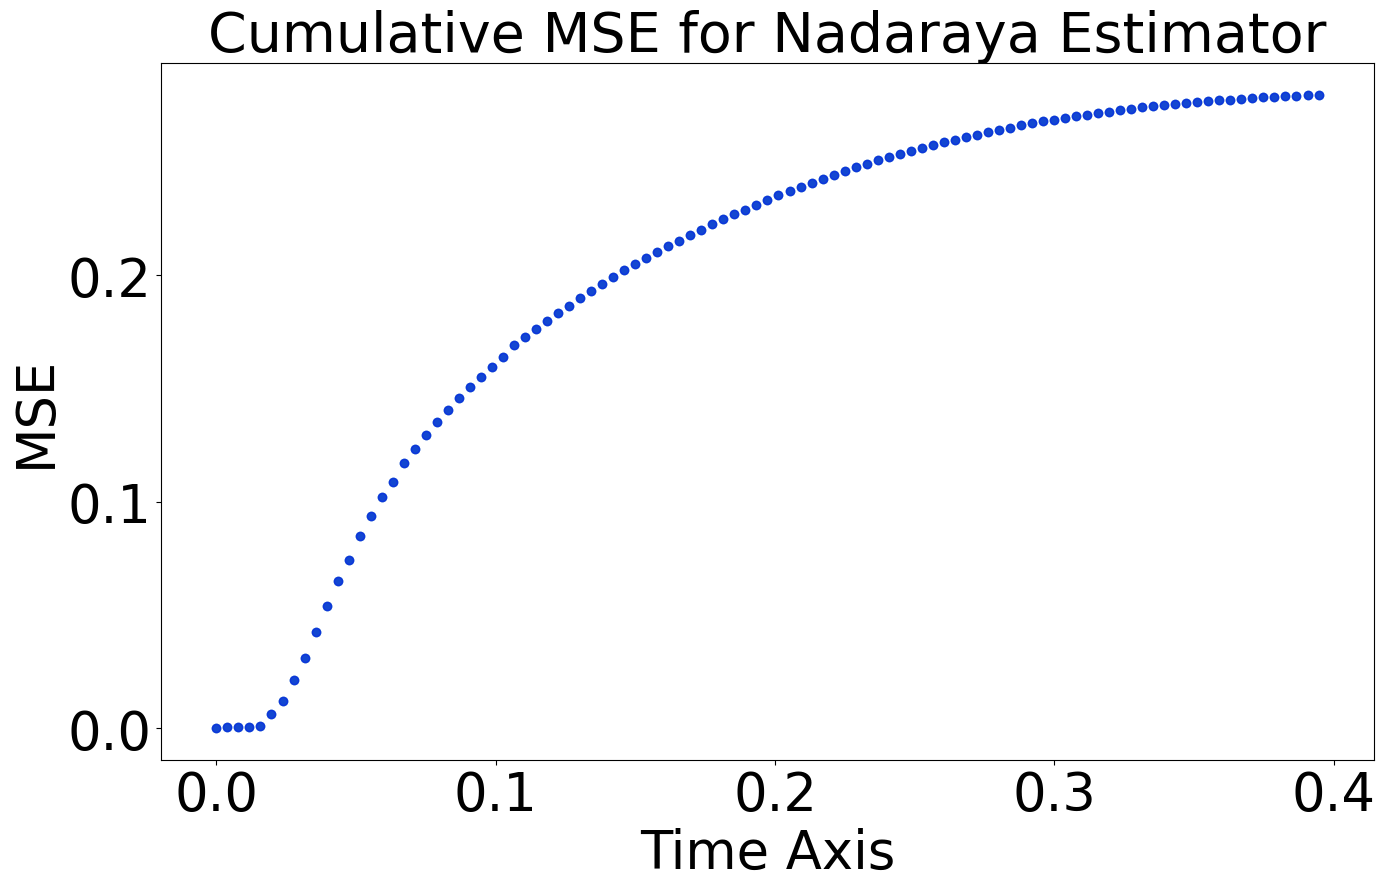

Final time cumulative MSE local-time error 0.279641812508214 with IQR ((0.279641812508214, 0.279641812508214))at bw 0.0034045 for 1.25FConst

0.26905456706175096 0.0 0.279641812508214 26


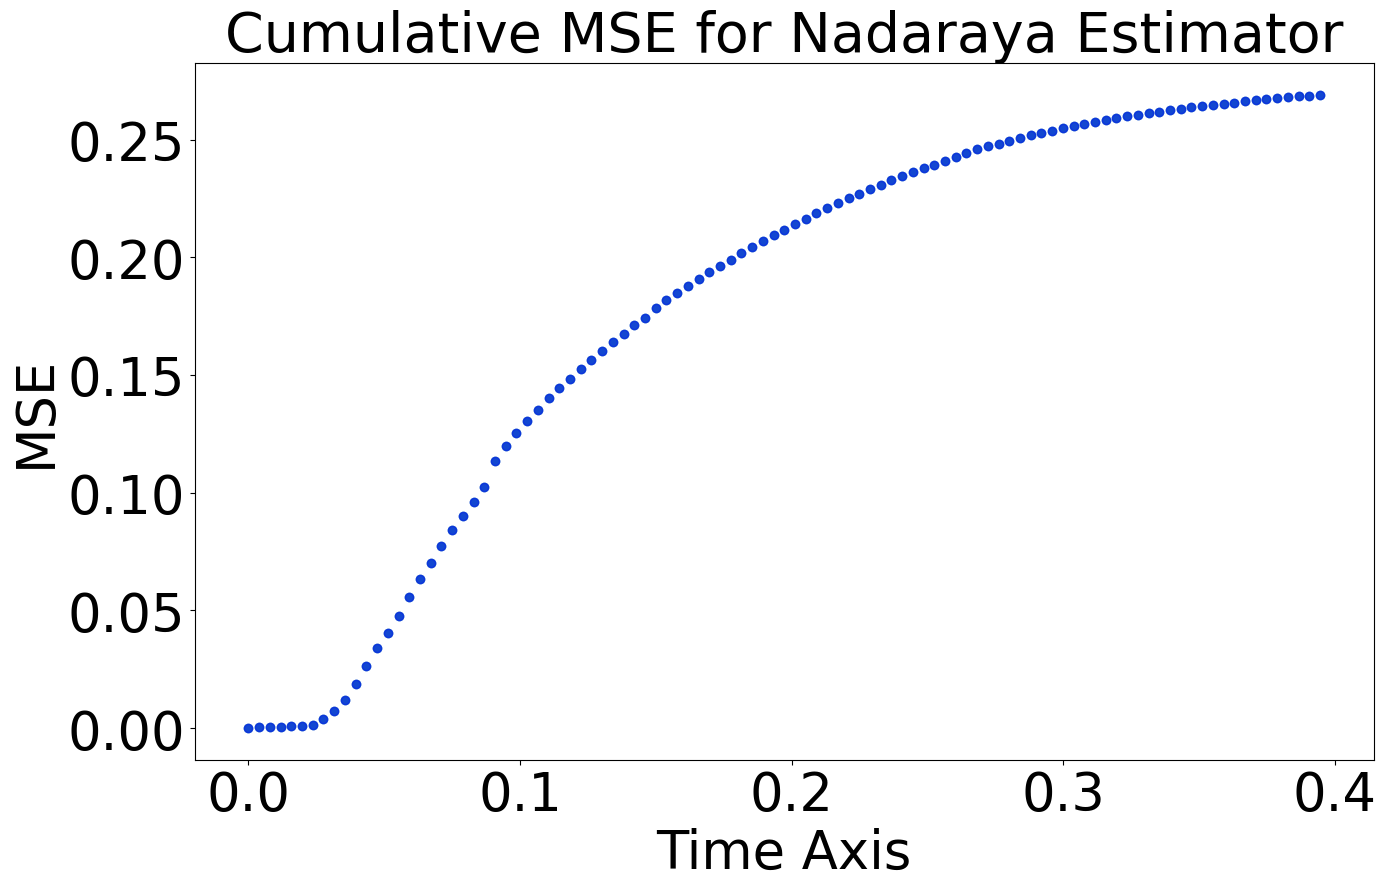

Final time cumulative MSE local-time error 0.26905456706175096 with IQR ((0.26905456706175096, 0.26905456706175096))at bw 0.0042987 for 1.25FConst

0.24731006446273227 0.0 0.26905456706175096 27


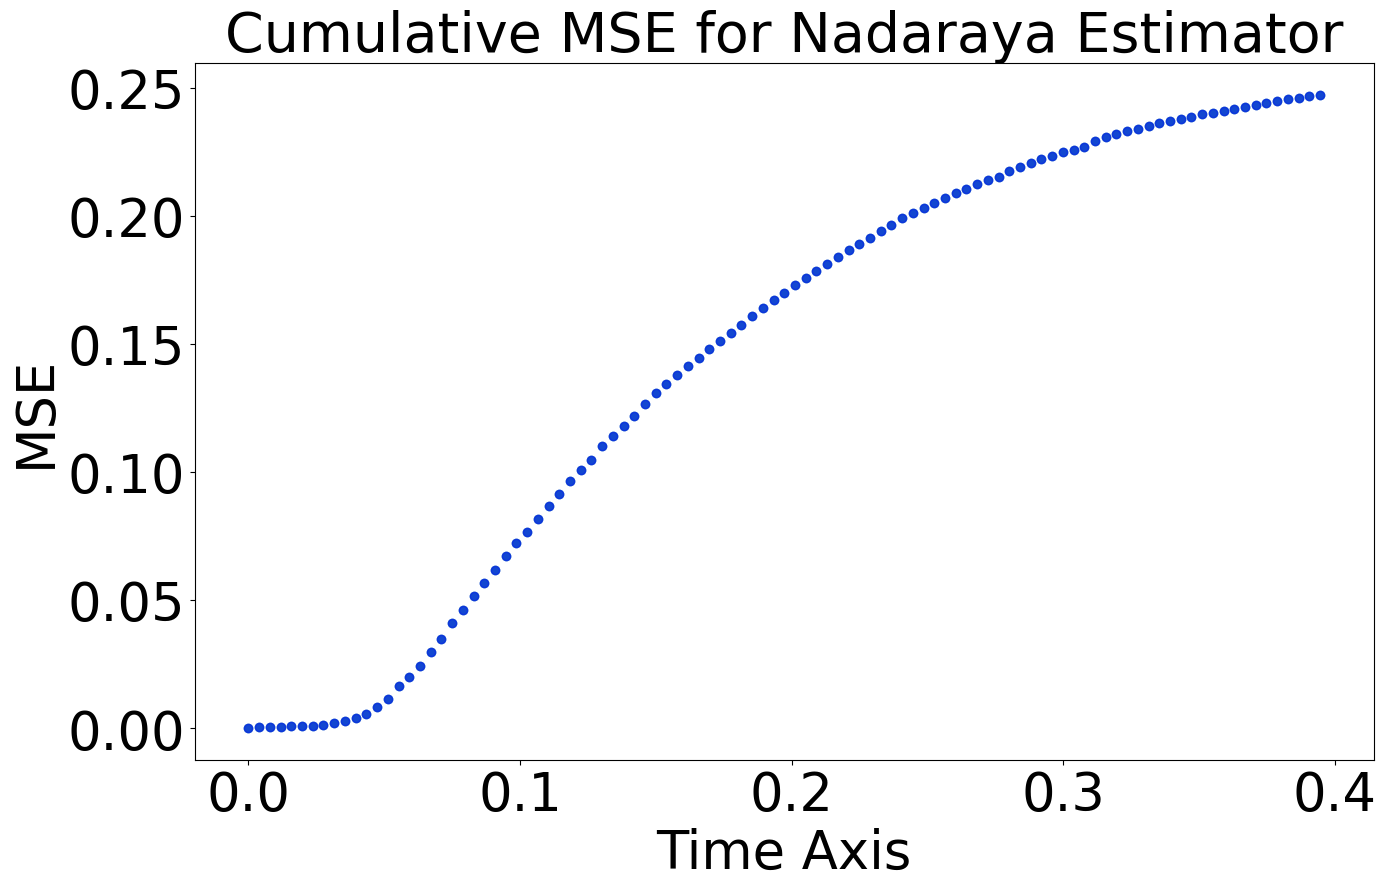

Final time cumulative MSE local-time error 0.24731006446273227 with IQR ((0.24731006446273227, 0.24731006446273227))at bw 0.0054277 for 1.25FConst

0.2086589073334028 0.0 0.24731006446273227 28


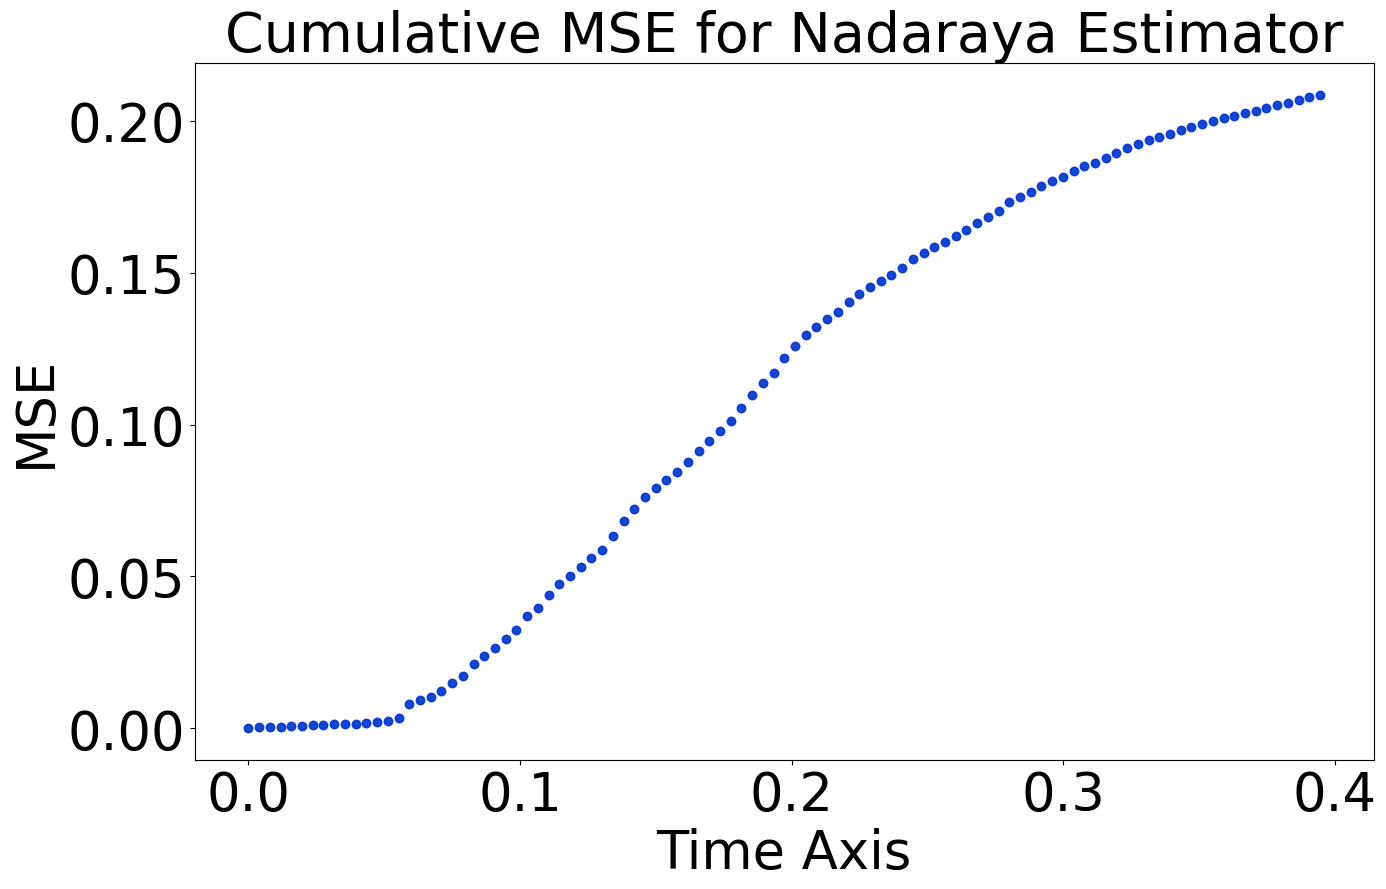

Final time cumulative MSE local-time error 0.2086589073334028 with IQR ((0.20865890733340284, 0.20865890733340284))at bw 0.0068533 for 1.25FConst

0.1459052332385493 0.0 0.2086589073334028 29


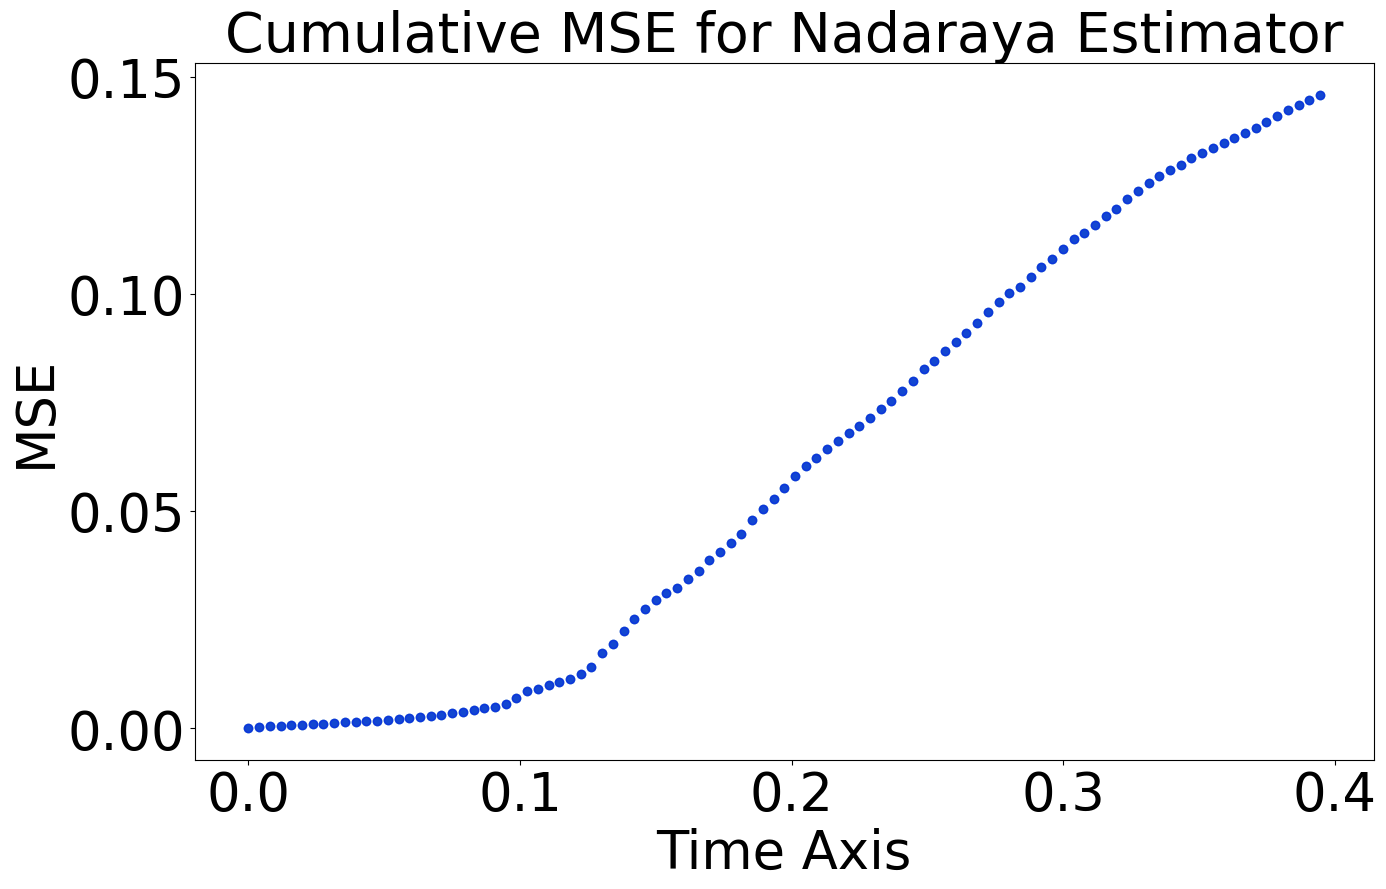

Final time cumulative MSE local-time error 0.1459052332385493 with IQR ((0.1459052332385493, 0.1459052332385493))at bw 0.0086533 for 1.25FConst

0.06885742260246983 0.0 0.1459052332385493 30


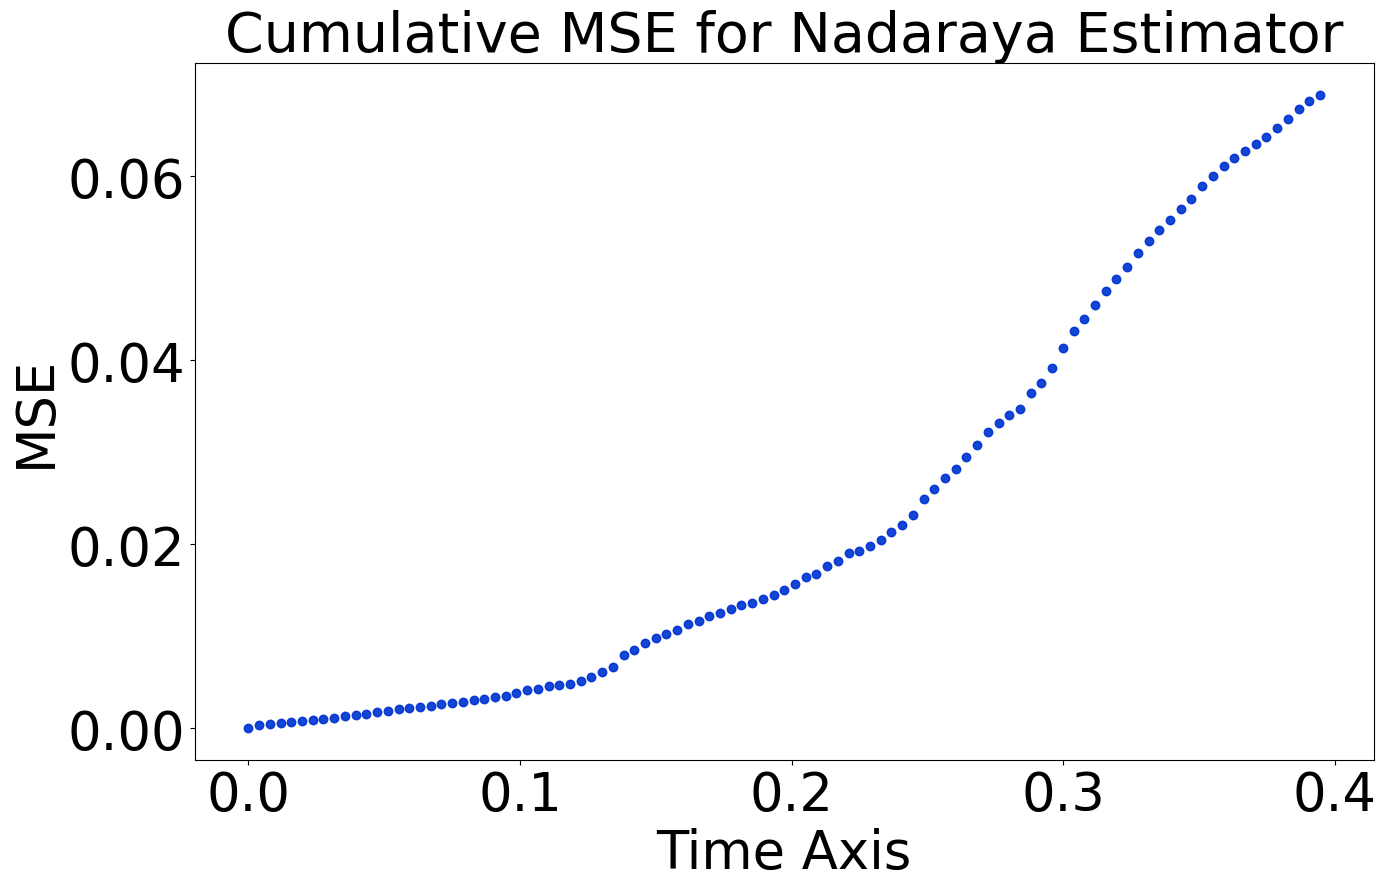

Final time cumulative MSE local-time error 0.06885742260246983 with IQR ((0.06885742260246981, 0.06885742260246981))at bw 0.010926 for 1.25FConst

0.025363362940839303 0.0 0.06885742260246983 31


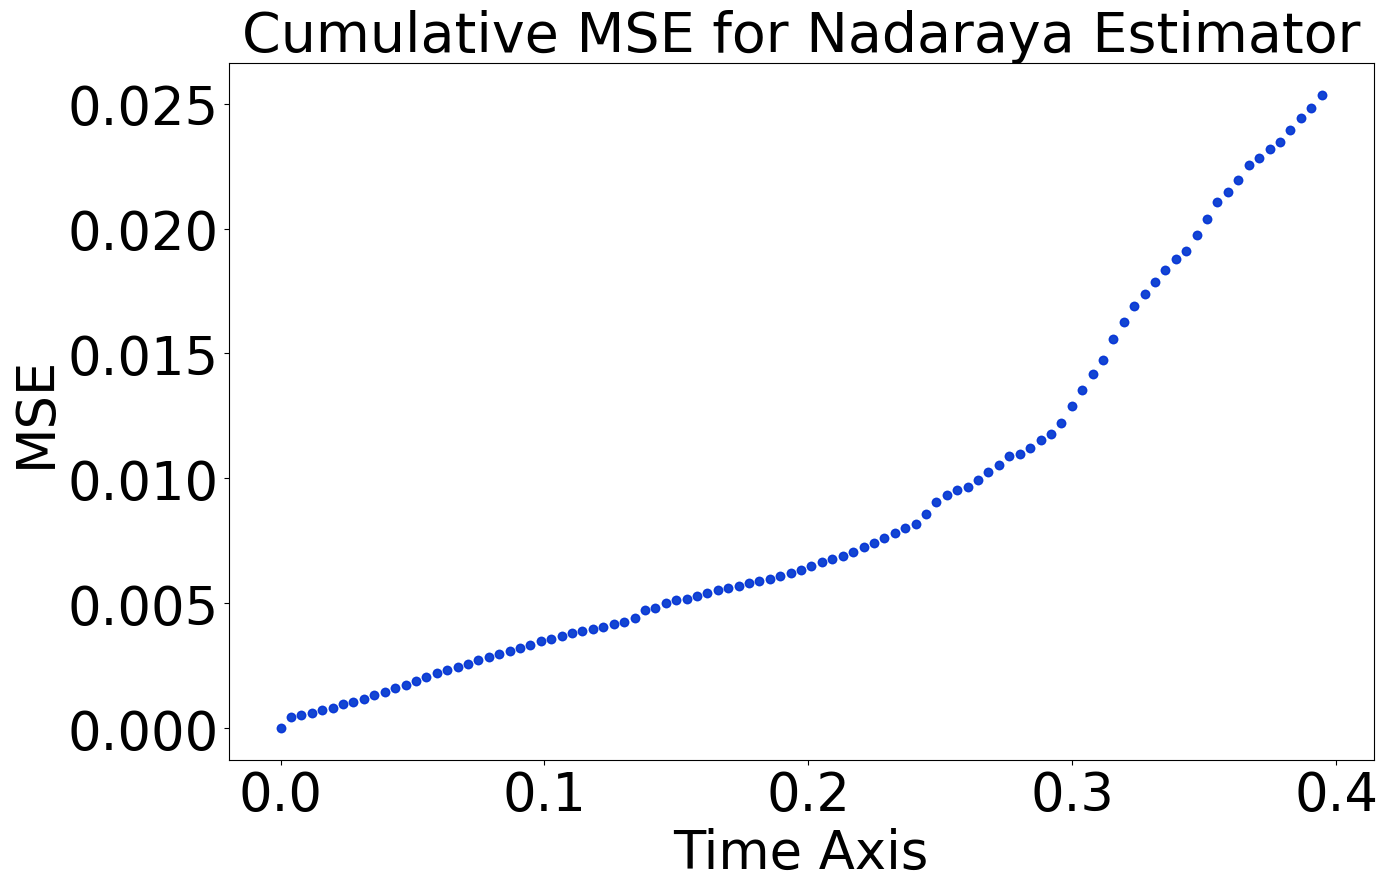

Final time cumulative MSE local-time error 0.025363362940839303 with IQR ((0.025363362940839306, 0.025363362940839306))at bw 0.0137957 for 1.25FConst

0.01100252525348755 0.0 0.025363362940839303 32


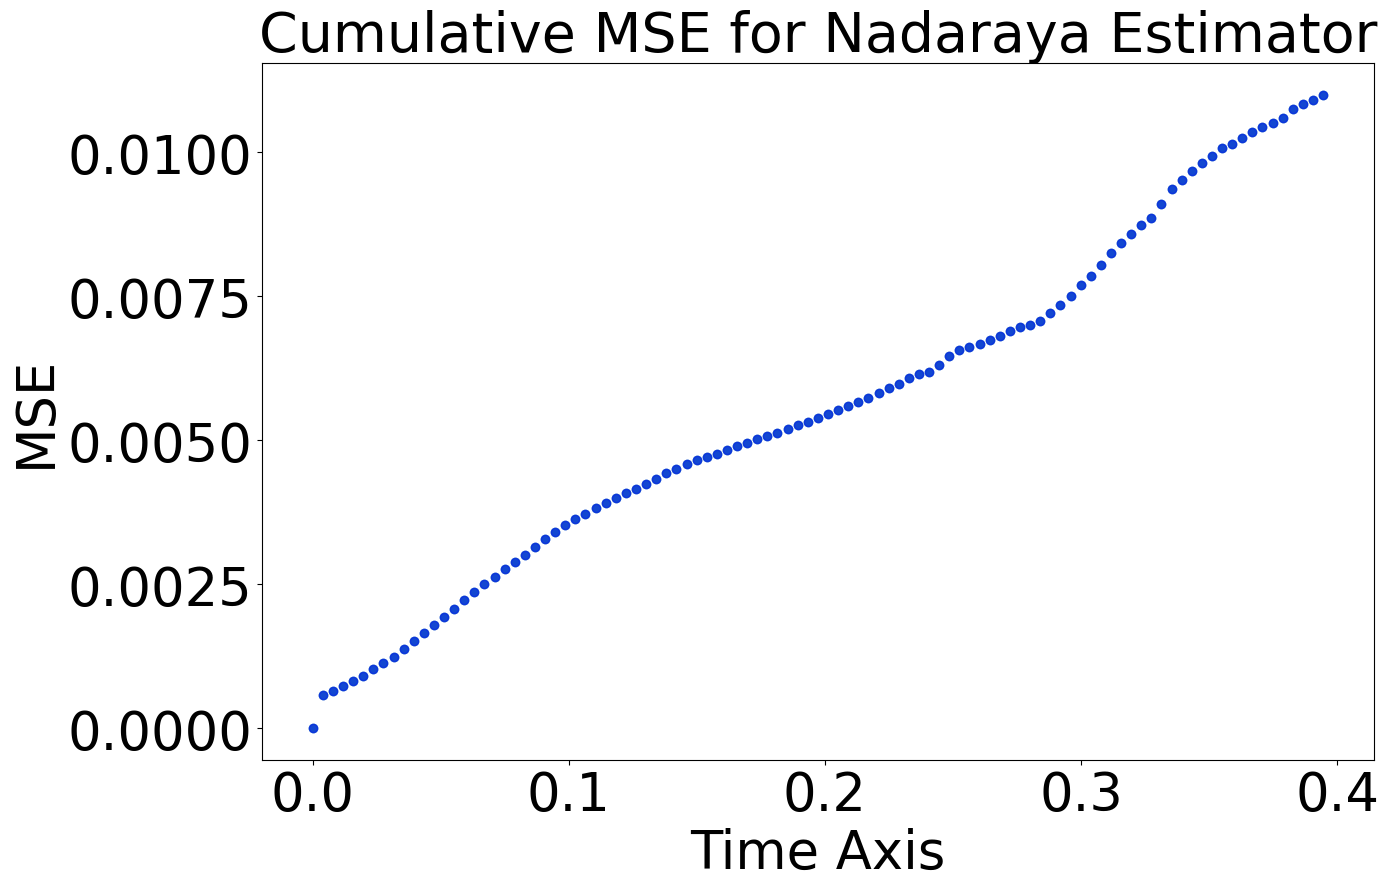

Final time cumulative MSE local-time error 0.01100252525348755 with IQR ((0.01100252525348755, 0.01100252525348755))at bw 0.0174191 for 1.25FConst

0.007736347182466563 0.0 0.01100252525348755 33


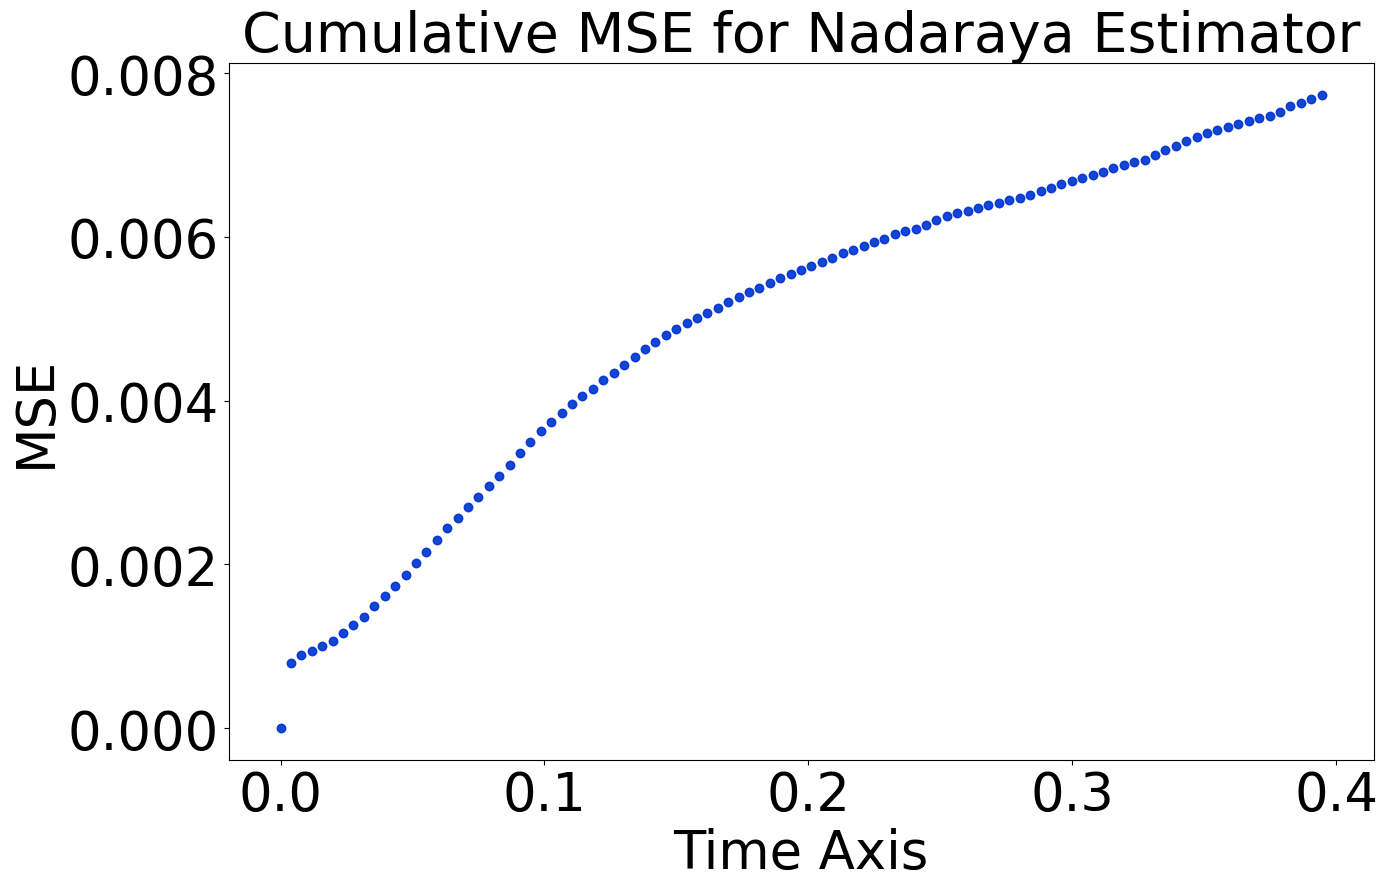

Final time cumulative MSE local-time error 0.007736347182466563 with IQR ((0.007736347182466561, 0.007736347182466561))at bw 0.0219942 for 1.25FConst

0.007602110791870317 0.0 0.007736347182466563 34


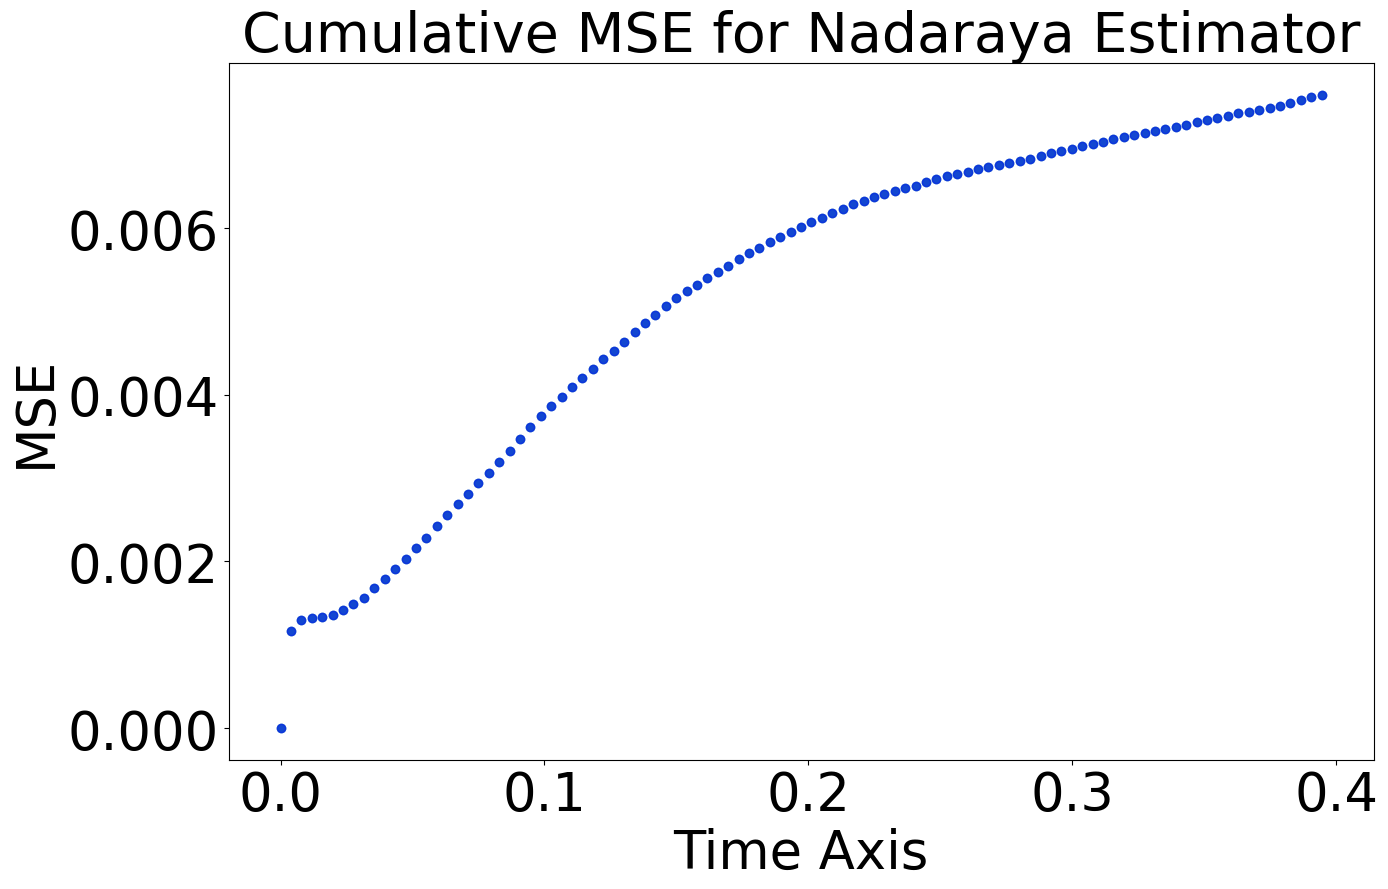

Final time cumulative MSE local-time error 0.007602110791870317 with IQR ((0.007602110791870319, 0.007602110791870319))at bw 0.0277709 for 1.25FConst

0.00811040590640556 0.0 0.007602110791870317 35
0.008838885745465926 0.0 0.007602110791870317 36
0.009749478846961644 0.0 0.007602110791870317 37
0.010868562019297564 0.0 0.007602110791870317 38
0.012280975753298314 0.0 0.007602110791870317 39


In [5]:
curr_rmse = np.inf
toSave = True
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])/np.sqrt(config.deltaT)
    all_local_states = np.load(file[1])/np.sqrt(config.deltaT)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        total_local_errors_minq = np.quantile((all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile((all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse, i)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            miny = total_local_errors-total_local_errors_minq
            miny[miny < 0.] = 0.
            maxy = total_local_errors_maxq-total_local_errors
            maxy[maxy < 0.] = 0.
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            plt.errorbar(time_steps,total_local_errors,yerr=[miny, maxy],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative MSE for Nadaraya Estimator",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/IIDNadaraya_12DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 4)}_MinIQR_{round(total_local_errors_maxq[-1], 4)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")